    About the labels
        # 0 negative
        # 1 neutral
        # 2 positive

In [1]:
#!pip install transformers[torch]
#!pip install torch transformers datasets
#!pip install accelerate -U

# Getting ready the work environment. Importing libraries and modules: 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import time
import pandas as pd

from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

C:\Users\nonox\anaconda3\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\nonox\anaconda3\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Time consumed (starts)
start_time = time.time()

# Loading the pre-trained FinBERT model and tokenizer
model_ = "ProsusAI/finbert"
tokenizer = BertTokenizer.from_pretrained(model_)
model = BertForSequenceClassification.from_pretrained(model_)

# We directly load the Financial PhraseBank dataset from The Hugging Face
dataset = load_dataset("financial_phrasebank", "sentences_allagree") # https://huggingface.co/datasets/financial_phrasebank/viewer/sentences_allagree
#"sentences_50agree"
#"sentences_66agree"
#"sentences_75agree"

Found cached dataset financial_phrasebank (C:/Users/nonox/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["sentence"],
                     padding="longest", 
                     max_length= 45, 
                     truncation = True)

dataset = dataset.map(preprocess_function, batched=True)

# Split the dataset into training and validation sets
train_test_split = dataset['train'].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']



Loading cached processed dataset at C:\Users\nonox\.cache\huggingface\datasets\financial_phrasebank\sentences_allagree\1.0.0\550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141\cache-ab52e02081578aae.arrow
Loading cached split indices for dataset at C:\Users\nonox\.cache\huggingface\datasets\financial_phrasebank\sentences_allagree\1.0.0\550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141\cache-10a3db2b34327c77.arrow and C:\Users\nonox\.cache\huggingface\datasets\financial_phrasebank\sentences_allagree\1.0.0\550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141\cache-f1ca108c82a0a6c4.arrow


In [4]:
# Training arguments
training_args = TrainingArguments(
    output_dir = "./results",
    evaluation_strategy = "epoch",
    learning_rate = 0.0001,
    per_device_train_batch_size = 25,
    per_device_eval_batch_size = 25,
    num_train_epochs = 2,
    warmup_steps = 500,
    save_strategy = "epoch"
)

# Define the trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
)

# Fine-tune the model
trainer.train()

C:\Users\nonox\anaconda3\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.401435
2,No log,0.137344


TrainOutput(global_step=146, training_loss=1.0236330424269584, metrics={'train_runtime': 1014.7056, 'train_samples_per_second': 3.57, 'train_steps_per_second': 0.144, 'total_flos': 83759484288060.0, 'train_loss': 1.0236330424269584, 'epoch': 2.0})

In [5]:
# Evaluate the fine-tuned model
predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = eval_dataset["label"]
accuracy = accuracy_score(labels, preds)
report = classification_report(labels, preds)

print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Classification Report:\n{report}")

Validation Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        73
           1       0.99      0.98      0.98       280
           2       0.92      0.93      0.93       100

    accuracy                           0.96       453
   macro avg       0.93      0.93      0.93       453
weighted avg       0.96      0.96      0.96       453



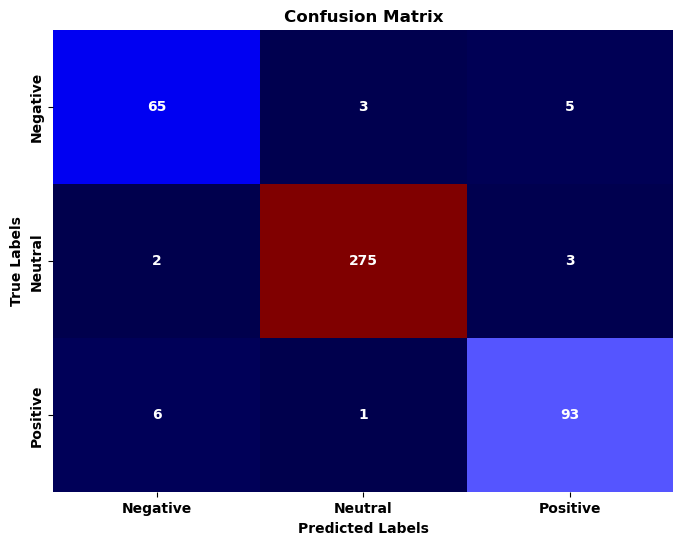

In [6]:
# Confusion matrix
cm =  confusion_matrix(labels, preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6)) 

sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='seismic', 
            cbar=False, 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


plt.show()

In [7]:
# Load the test dataset
test_dataset = load_dataset("financial_phrasebank", "sentences_75agree")
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Evaluate the fine-tuned model on the test set
test_predictions = trainer.predict(test_dataset['train'])
test_preds = np.argmax(test_predictions.predictions, axis=1)
test_labels = test_dataset['train']["label"]
test_accuracy = accuracy_score(test_labels, test_preds)
test_report = classification_report(test_labels, test_preds)


Found cached dataset financial_phrasebank (C:/Users/nonox/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\nonox\.cache\huggingface\datasets\financial_phrasebank\sentences_75agree\1.0.0\550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141\cache-06dc7416bca07405.arrow


In [8]:
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Classification Report:\n{test_report}")

Test Accuracy: 0.93
Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       420
           1       0.96      0.95      0.96      2146
           2       0.89      0.90      0.89       887

    accuracy                           0.93      3453
   macro avg       0.89      0.90      0.90      3453
weighted avg       0.93      0.93      0.93      3453



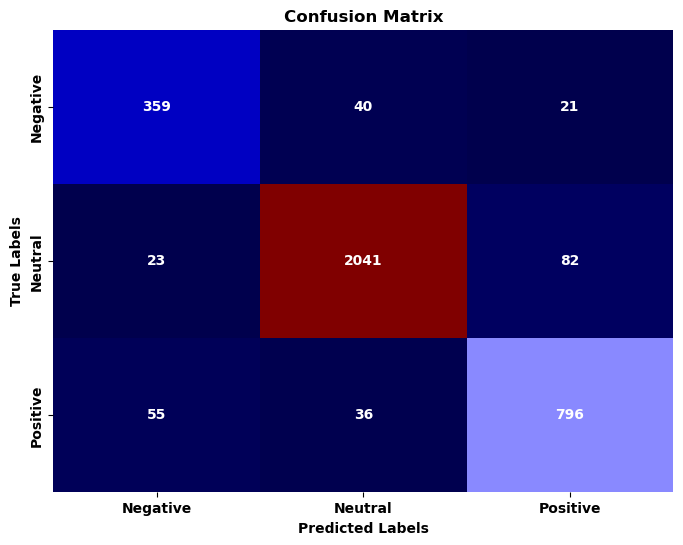

In [9]:
# Confusion matrix
test_cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6)) 

sns.heatmap(test_cm, 
            annot=True, 
            fmt='d', 
            cmap='seismic', 
            cbar=False, 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')


plt.show()

In [10]:
# Total Time Consumed 
end_time = time.time()
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time} seconds")

Total Execution Time: 1322.466394662857 seconds
